# IEEE-CIS Fraud Detection - Model Building & Evaluation

## Overview
This notebook builds and compares multiple machine learning models for fraud detection:

1. **Logistic Regression** - Baseline linear model
2. **Random Forest** - Ensemble tree model
3. **XGBoost** - Gradient boosting
4. **LightGBM** - Fast gradient boosting

### Key Metrics Focus:
- **Recall (Sensitivity)**: Catching as many frauds as possible
- **Precision**: Minimizing false alarms
- **F1-Score**: Balance between Precision and Recall
- **AUC-ROC**: Overall model discrimination ability

In [1]:
!pip install xgboost lightgbm

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import joblib

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

# Boosting models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")
os.makedirs("outputs", exist_ok=True)

print("Libraries imported successfully")

Libraries imported successfully


##  Load Preprocessed Data

In [3]:
# Load preprocessed data from outputs folder
print("Loading preprocessed data...")

# Scaled data (for Logistic Regression)
X_train_scaled = pd.read_csv("outputs/X_train_scaled.csv")
X_test_scaled = pd.read_csv("outputs/X_test_scaled.csv")

# Unscaled data (for tree-based models)
X_train = pd.read_csv("outputs/X_train_balanced.csv")
X_test = pd.read_csv("outputs/X_test.csv")

# Labels
y_train = pd.read_csv("outputs/y_train_balanced.csv").values.ravel()
y_test = pd.read_csv("outputs/y_test.csv").values.ravel()

print(f"Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\n Training class distribution:")
print(f"   Non-Fraud: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.1f}%)")
print(f"   Fraud: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.1f}%)")
print(f"\n Test class distribution:")
print(f"   Non-Fraud: {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.1f}%)")
print(f"   Fraud: {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.1f}%)")

Loading preprocessed data...


Training set: 683,853 samples, 404 features
Test set: 118,108 samples

 Training class distribution:
   Non-Fraud: 455,902 (66.7%)
   Fraud: 227,951 (33.3%)

 Test class distribution:
   Non-Fraud: 113,975 (96.5%)
   Fraud: 4,133 (3.5%)


##  Define Evaluation Functions

In [4]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate model and return metrics dictionary
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1_Score': f1_score(y_test, y_pred),
        'AUC_ROC': roc_auc_score(y_test, y_prob),
        'Avg_Precision': average_precision_score(y_test, y_prob)
    }

    return metrics, y_pred, y_prob


def plot_confusion_matrix(y_test, y_pred, model_name, ax):
    """
    Plot confusion matrix on given axis
    """
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    ax.set_title(f'{model_name}\nConfusion Matrix')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

    # Add percentages
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            pct = cm[i, j] / total * 100
            ax.text(j + 0.5, i + 0.7, f'({pct:.1f}%)',
                   ha='center', va='center', fontsize=9, color='gray')


def plot_roc_curve(y_test, y_prob, model_name, ax, color):
    """
    Plot ROC curve on given axis
    """
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC={auc:.3f})')


def plot_precision_recall_curve(y_test, y_prob, model_name, ax, color):
    """
    Plot Precision-Recall curve on given axis
    """
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    ax.plot(recall, precision, color=color, lw=2, label=f'{model_name} (AP={ap:.3f})')


print(" Evaluation functions defined")

 Evaluation functions defined


In [5]:
# Storage for results
all_results = []
all_predictions = {}
all_probabilities = {}

# Colors for plots
model_colors = {
    'Logistic Regression': '#1f77b4',
    'Random Forest': '#2ca02c',
    'XGBoost': '#ff7f0e',
    'LightGBM': '#d62728'
}

print("Ready to train models")

Ready to train models


## Model 1: Logistic Regression
A linear baseline model. Uses **scaled data** for optimal performance.

In [6]:
print("=" * 60)
print("Training Logistic Regression...")
print("=" * 60)

# Train model
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',  # Additional handling for imbalance
    n_jobs=-1
)

lr_model.fit(X_train_scaled, y_train)

# Evaluate
lr_metrics, lr_pred, lr_prob = evaluate_model(lr_model, X_test_scaled, y_test, 'Logistic Regression')
all_results.append(lr_metrics)
all_predictions['Logistic Regression'] = lr_pred
all_probabilities['Logistic Regression'] = lr_prob

print(f"\n Logistic Regression Results:")
print(f"   Accuracy:  {lr_metrics['Accuracy']:.4f}")
print(f"   Precision: {lr_metrics['Precision']:.4f}")
print(f"   Recall:    {lr_metrics['Recall']:.4f}")
print(f"   F1-Score:  {lr_metrics['F1_Score']:.4f}")
print(f"   AUC-ROC:   {lr_metrics['AUC_ROC']:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, lr_pred, target_names=['Non-Fraud', 'Fraud']))

Training Logistic Regression...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Logistic Regression Results:
   Accuracy:  0.9470
   Precision: 0.3222
   Recall:    0.4662
   F1-Score:  0.3811
   AUC-ROC:   0.8332

 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.96      0.97    113975
       Fraud       0.32      0.47      0.38      4133

    accuracy                           0.95    118108
   macro avg       0.65      0.72      0.68    118108
weighted avg       0.96      0.95      0.95    118108



## Model 2: Random Forest
Ensemble of decision trees. Uses **unscaled data** (tree-based models don't need scaling).

In [7]:
print("=" * 60)
print("Training Random Forest...")
print("=" * 60)

# Train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Evaluate
rf_metrics, rf_pred, rf_prob = evaluate_model(rf_model, X_test, y_test, 'Random Forest')
all_results.append(rf_metrics)
all_predictions['Random Forest'] = rf_pred
all_probabilities['Random Forest'] = rf_prob

print(f"\n Random Forest Results:")
print(f"   Accuracy:  {rf_metrics['Accuracy']:.4f}")
print(f"   Precision: {rf_metrics['Precision']:.4f}")
print(f"   Recall:    {rf_metrics['Recall']:.4f}")
print(f"   F1-Score:  {rf_metrics['F1_Score']:.4f}")
print(f"   AUC-ROC:   {rf_metrics['AUC_ROC']:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, rf_pred, target_names=['Non-Fraud', 'Fraud']))

Training Random Forest...

 Random Forest Results:
   Accuracy:  0.9730
   Precision: 0.6613
   Recall:    0.4687
   F1-Score:  0.5486
   AUC-ROC:   0.8976

📋 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.99      0.99    113975
       Fraud       0.66      0.47      0.55      4133

    accuracy                           0.97    118108
   macro avg       0.82      0.73      0.77    118108
weighted avg       0.97      0.97      0.97    118108



##  Model 3: XGBoost
Gradient boosting with regularization. Highly effective for tabular data.

In [8]:
print("=" * 60)
print("Training XGBoost...")
print("=" * 60)

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Evaluate
xgb_metrics, xgb_pred, xgb_prob = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')
all_results.append(xgb_metrics)
all_predictions['XGBoost'] = xgb_pred
all_probabilities['XGBoost'] = xgb_prob

print(f"\n XGBoost Results:")
print(f"   Accuracy:  {xgb_metrics['Accuracy']:.4f}")
print(f"   Precision: {xgb_metrics['Precision']:.4f}")
print(f"   Recall:    {xgb_metrics['Recall']:.4f}")
print(f"   F1-Score:  {xgb_metrics['F1_Score']:.4f}")
print(f"   AUC-ROC:   {xgb_metrics['AUC_ROC']:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, xgb_pred, target_names=['Non-Fraud', 'Fraud']))

Training XGBoost...

 XGBoost Results:
   Accuracy:  0.9748
   Precision: 0.7195
   Recall:    0.4587
   F1-Score:  0.5603
   AUC-ROC:   0.9062

📋 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.99      0.99    113975
       Fraud       0.72      0.46      0.56      4133

    accuracy                           0.97    118108
   macro avg       0.85      0.73      0.77    118108
weighted avg       0.97      0.97      0.97    118108



## Model 4: LightGBM
Fast gradient boosting framework. Efficient for large datasets.

In [9]:
print("=" * 60)
print("Training LightGBM...")
print("=" * 60)

# Train model
lgb_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    class_weight='balanced',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train)

# Evaluate
lgb_metrics, lgb_pred, lgb_prob = evaluate_model(lgb_model, X_test, y_test, 'LightGBM')
all_results.append(lgb_metrics)
all_predictions['LightGBM'] = lgb_pred
all_probabilities['LightGBM'] = lgb_prob

print(f"\n LightGBM Results:")
print(f"   Accuracy:  {lgb_metrics['Accuracy']:.4f}")
print(f"   Precision: {lgb_metrics['Precision']:.4f}")
print(f"   Recall:    {lgb_metrics['Recall']:.4f}")
print(f"   F1-Score:  {lgb_metrics['F1_Score']:.4f}")
print(f"   AUC-ROC:   {lgb_metrics['AUC_ROC']:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, lgb_pred, target_names=['Non-Fraud', 'Fraud']))

Training LightGBM...

 LightGBM Results:
   Accuracy:  0.9738
   Precision: 0.6918
   Recall:    0.4529
   F1-Score:  0.5474
   AUC-ROC:   0.9042

📋 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.99      0.99    113975
       Fraud       0.69      0.45      0.55      4133

    accuracy                           0.97    118108
   macro avg       0.84      0.72      0.77    118108
weighted avg       0.97      0.97      0.97    118108



## 7️⃣ Model Comparison

In [10]:
# Create results DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index('Model')

# Display comparison table
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(results_df.round(4).to_string())

# Highlight best model for each metric
print("\n Best Model by Metric:")
for col in results_df.columns:
    best_model = results_df[col].idxmax()
    best_value = results_df[col].max()
    print(f"   {col}: {best_model} ({best_value:.4f})")

MODEL COMPARISON SUMMARY
                     Accuracy  Precision  Recall  F1_Score  AUC_ROC  Avg_Precision
Model                                                                             
Logistic Regression    0.9470     0.3222  0.4662    0.3811   0.8332         0.3914
Random Forest          0.9730     0.6613  0.4687    0.5486   0.8976         0.5623
XGBoost                0.9748     0.7195  0.4587    0.5603   0.9062         0.5811
LightGBM               0.9738     0.6918  0.4529    0.5474   0.9042         0.5670

 Best Model by Metric:
   Accuracy: XGBoost (0.9748)
   Precision: XGBoost (0.7195)
   Recall: Random Forest (0.4687)
   F1_Score: XGBoost (0.5603)
   AUC_ROC: XGBoost (0.9062)
   Avg_Precision: XGBoost (0.5811)


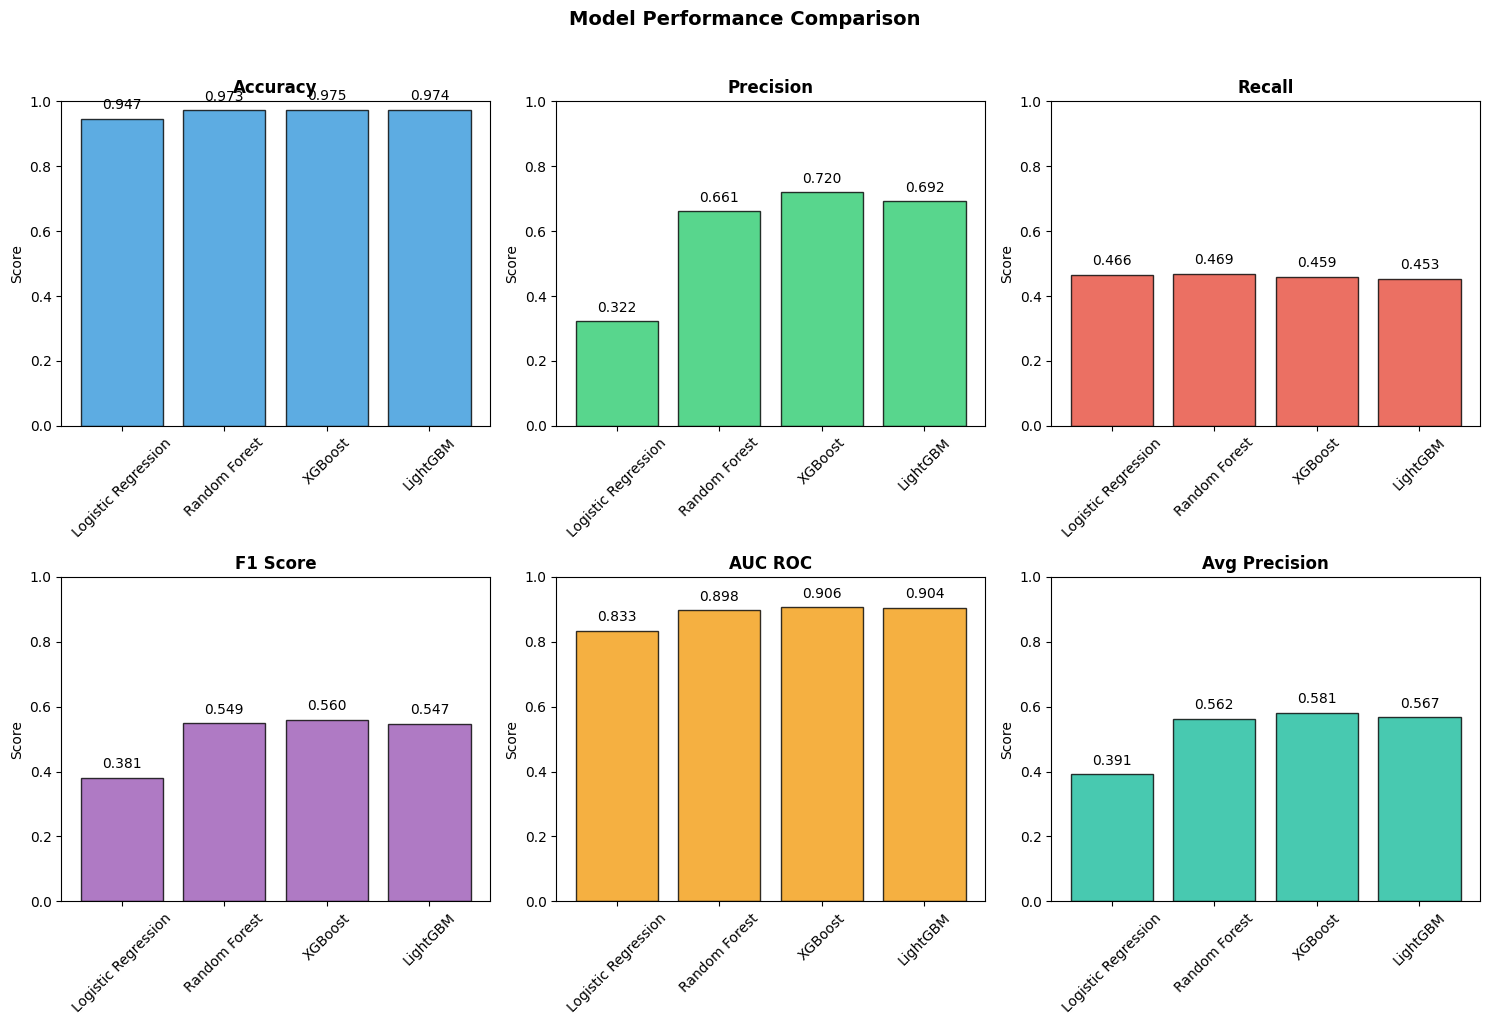

 Saved: outputs/model_comparison_metrics.png


In [11]:
# Visual comparison of metrics
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC_ROC', 'Avg_Precision']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    values = results_df[metric].values
    models = results_df.index.tolist()

    bars = ax.bar(models, values, color=colors[idx], edgecolor='black', alpha=0.8)
    ax.set_title(metric.replace('_', ' '), fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')

    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)

    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('outputs/model_comparison_metrics.png', dpi=150, bbox_inches='tight')
plt.show()
print(" Saved: outputs/model_comparison_metrics.png")

## Confusion Matrices

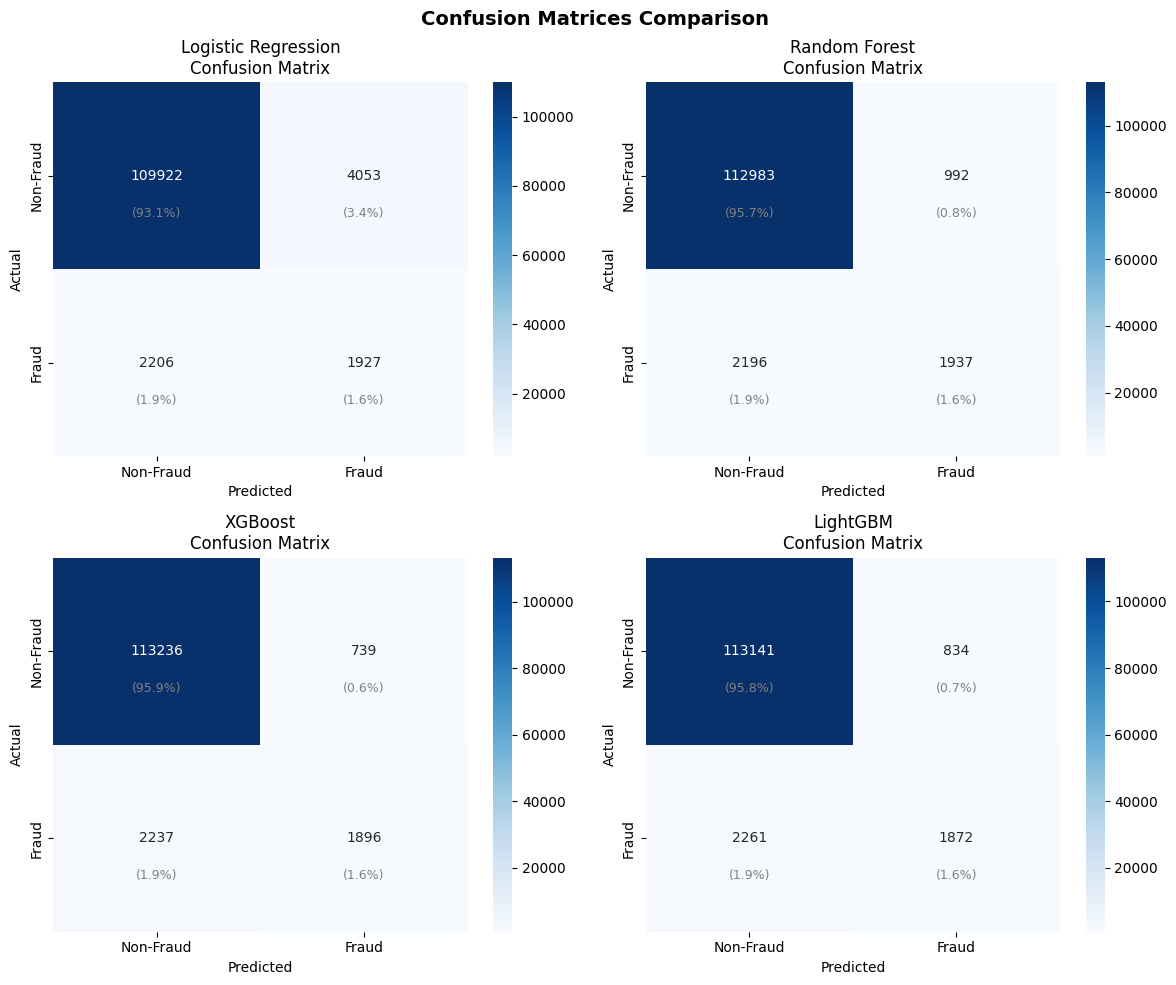

Saved: outputs/confusion_matrices.png


In [12]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models_data = [
    ('Logistic Regression', lr_pred),
    ('Random Forest', rf_pred),
    ('XGBoost', xgb_pred),
    ('LightGBM', lgb_pred)
]

for idx, (name, pred) in enumerate(models_data):
    ax = axes[idx // 2, idx % 2]
    plot_confusion_matrix(y_test, pred, name, ax)

plt.suptitle('Confusion Matrices Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: outputs/confusion_matrices.png")

##  ROC and Precision-Recall Curves

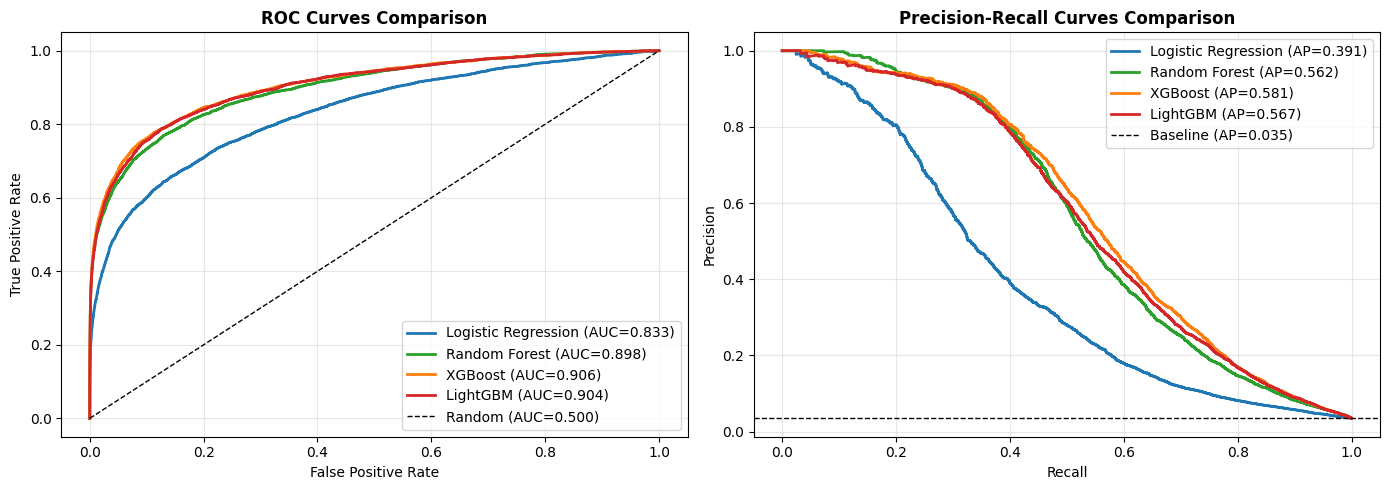

📁 Saved: outputs/roc_pr_curves.png


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
ax1 = axes[0]
for model_name, y_prob in all_probabilities.items():
    plot_roc_curve(y_test, y_prob, model_name, ax1, model_colors[model_name])

ax1.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC=0.500)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves Comparison', fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Precision-Recall Curves
ax2 = axes[1]
for model_name, y_prob in all_probabilities.items():
    plot_precision_recall_curve(y_test, y_prob, model_name, ax2, model_colors[model_name])

# Baseline (proportion of positive class)
baseline = y_test.mean()
ax2.axhline(y=baseline, color='k', linestyle='--', lw=1, label=f'Baseline (AP={baseline:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves Comparison', fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: outputs/roc_pr_curves.png")

## Feature Importance Analysis

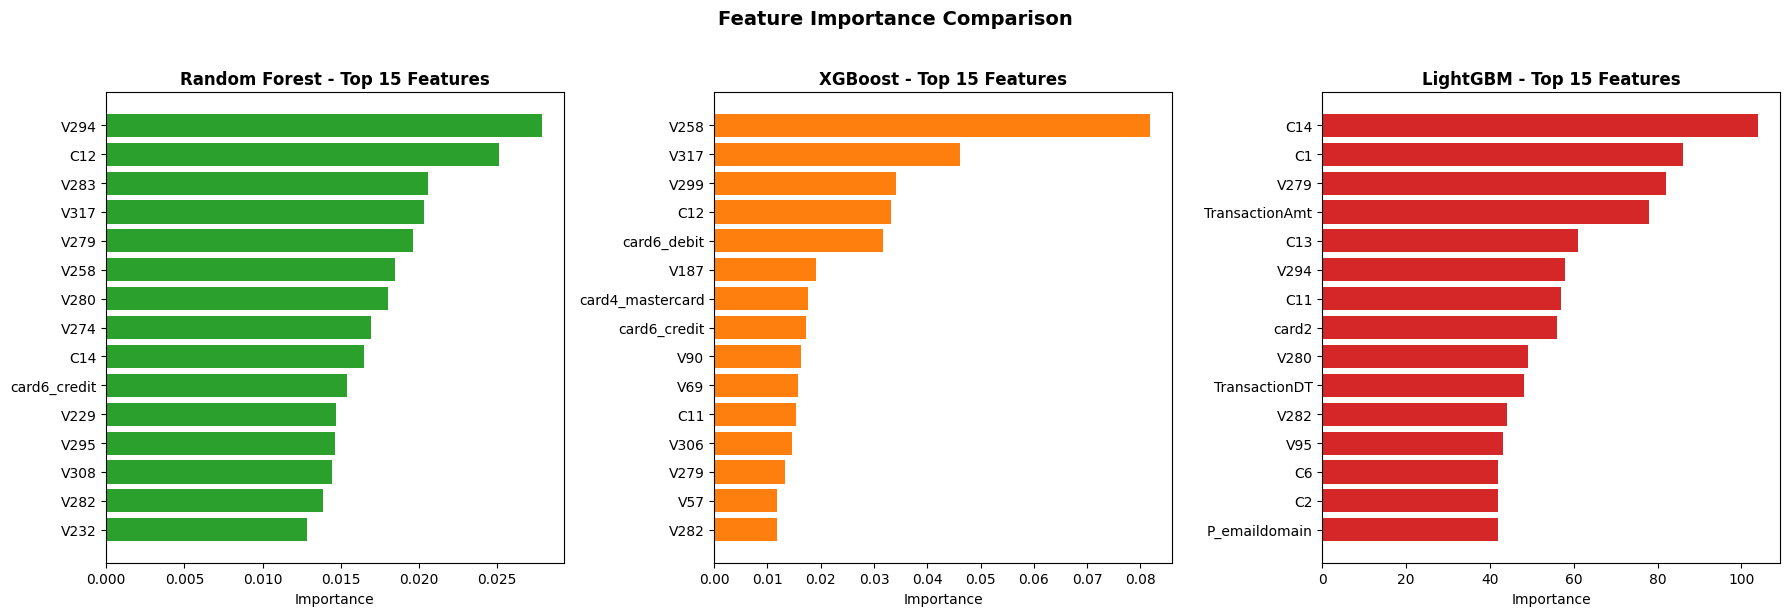

📁 Saved: outputs/feature_importance.png


In [14]:
# Get feature importance from tree-based models
feature_names = X_train.columns.tolist()

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# LightGBM feature importance
lgb_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (name, importance_df) in zip(axes, [
    ('Random Forest', rf_importance),
    ('XGBoost', xgb_importance),
    ('LightGBM', lgb_importance)
]):
    top_features = importance_df.head(15)
    ax.barh(top_features['feature'], top_features['importance'], color=model_colors[name])
    ax.set_xlabel('Importance')
    ax.set_title(f'{name} - Top 15 Features', fontweight='bold')
    ax.invert_yaxis()

plt.suptitle('Feature Importance Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('outputs/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("📁 Saved: outputs/feature_importance.png")

## Save Results for SQL Database

In [15]:
# Save model performance summary
results_df_export = results_df.reset_index()
results_df_export['Timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
results_df_export['Version'] = 'v1.0'
results_df_export.to_csv('outputs/model_performance_summary.csv', index=False)
print("Saved: outputs/model_performance_summary.csv")

# Save predictions for each model
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'LR_pred': lr_pred,
    'LR_prob': lr_prob,
    'RF_pred': rf_pred,
    'RF_prob': rf_prob,
    'XGB_pred': xgb_pred,
    'XGB_prob': xgb_prob,
    'LGB_pred': lgb_pred,
    'LGB_prob': lgb_prob
})
predictions_df.to_csv('outputs/model_predictions.csv', index=False)
print(" Saved: outputs/model_predictions.csv")

# Save feature importance
rf_importance.to_csv('outputs/feature_importance_rf.csv', index=False)
xgb_importance.to_csv('outputs/feature_importance_xgb.csv', index=False)
lgb_importance.to_csv('outputs/feature_importance_lgb.csv', index=False)
print(" Saved: Feature importance files")

print("\n All results saved for SQL database integration!")

Saved: outputs/model_performance_summary.csv
 Saved: outputs/model_predictions.csv
 Saved: Feature importance files

 All results saved for SQL database integration!


## Threshold Analysis for Best Model
Adjusting the classification threshold can improve Recall at the cost of Precision.

In [16]:
# Find best model by F1-Score
best_model_name = results_df['F1_Score'].idxmax()
best_prob = all_probabilities[best_model_name]

print(f"Analyzing thresholds for best model: {best_model_name}")
print("=" * 60)

# Analyze different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (best_prob >= thresh).astype(int)
    threshold_results.append({
        'Threshold': thresh,
        'Precision': precision_score(y_test, y_pred_thresh),
        'Recall': recall_score(y_test, y_pred_thresh),
        'F1_Score': f1_score(y_test, y_pred_thresh),
        'Fraud_Predicted': y_pred_thresh.sum()
    })

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df.round(4).to_string(index=False))

# Save threshold analysis
threshold_df.to_csv('outputs/threshold_analysis.csv', index=False)
print("\n Saved: outputs/threshold_analysis.csv")

Analyzing thresholds for best model: XGBoost
 Threshold  Precision  Recall  F1_Score  Fraud_Predicted
       0.1     0.1851  0.7868    0.2998            17565
       0.2     0.3374  0.6683    0.4484             8186
       0.3     0.4776  0.5826    0.5249             5042
       0.4     0.6088  0.5180    0.5597             3517
       0.5     0.7195  0.4587    0.5603             2635
       0.6     0.8032  0.4029    0.5366             2073
       0.7     0.8764  0.3516    0.5018             1658
       0.8     0.9119  0.2954    0.4463             1339

 Saved: outputs/threshold_analysis.csv


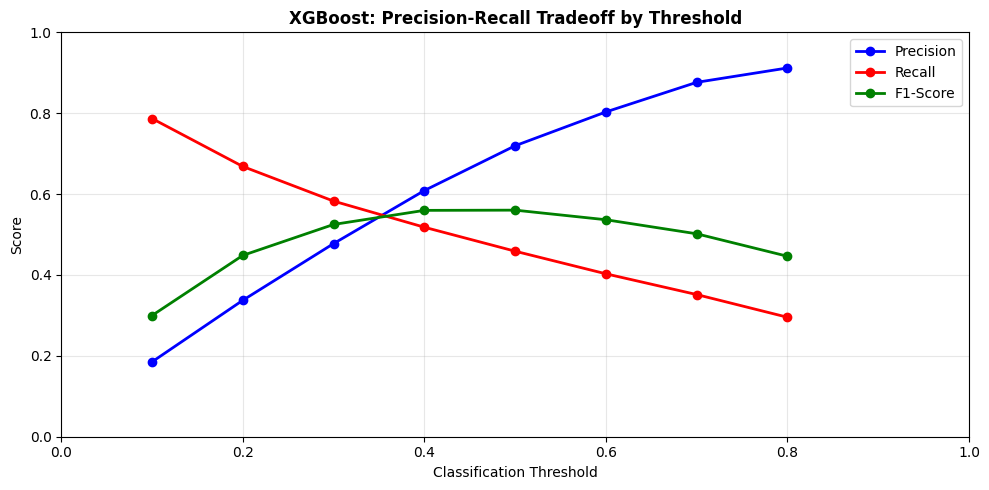

 Saved: outputs/threshold_analysis.png


In [17]:
# Plot Precision-Recall tradeoff by threshold
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(threshold_df['Threshold'], threshold_df['Precision'], 'b-o', label='Precision', lw=2)
ax.plot(threshold_df['Threshold'], threshold_df['Recall'], 'r-o', label='Recall', lw=2)
ax.plot(threshold_df['Threshold'], threshold_df['F1_Score'], 'g-o', label='F1-Score', lw=2)

ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Score')
ax.set_title(f'{best_model_name}: Precision-Recall Tradeoff by Threshold', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('outputs/threshold_analysis.png', dpi=150)
plt.show()
print(" Saved: outputs/threshold_analysis.png")

In [18]:
# Create models directory
os.makedirs('models', exist_ok=True)

# Save all trained models
print("Saving trained models...")

joblib.dump(lr_model, 'models/logistic_regression.pkl')
print("Saved: models/logistic_regression.pkl")

joblib.dump(rf_model, 'models/random_forest.pkl')
print("Saved: models/random_forest.pkl")

joblib.dump(xgb_model, 'models/xgboost.pkl')
print("Saved: models/xgboost.pkl")

joblib.dump(lgb_model, 'models/lightgbm.pkl')
print("Saved: models/lightgbm.pkl")

# Save feature names for later use
feature_names = pd.DataFrame({'feature': X_train.columns.tolist()})
feature_names.to_csv('outputs/feature_names.csv', index=False)
print("Saved: outputs/feature_names.csv")

print("\n All models saved successfully!")

Saving trained models...
Saved: models/logistic_regression.pkl
Saved: models/random_forest.pkl
Saved: models/xgboost.pkl
Saved: models/lightgbm.pkl
Saved: outputs/feature_names.csv

 All models saved successfully!


## Final Summary

In [19]:
print("=" * 80)
print("FRAUD DETECTION MODEL BUILDING - COMPLETE")
print("=" * 80)

print(f"""
Models Trained:
---------------
1. Logistic Regression (Linear baseline)
2. Random Forest (Ensemble trees)
3. XGBoost (Gradient boosting)
4. LightGBM (Fast gradient boosting)

Best Model by Metric:
---------------------""")

for col in ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC_ROC']:
    best = results_df[col].idxmax()
    val = results_df[col].max()
    print(f"  {col}: {best} ({val:.4f})")

print(f"""
Files Generated:
----------------
 outputs/model_performance_summary.csv  (for SQL)
 outputs/model_predictions.csv          (for SQL)
 outputs/threshold_analysis.csv         (for SQL)
 outputs/feature_importance_*.csv       (for analysis)
 outputs/model_comparison_metrics.png   (visualization)
 outputs/confusion_matrices.png         (visualization)
 outputs/roc_pr_curves.png              (visualization)
 outputs/feature_importance.png         (visualization)

Key Insights for Fraud Detection:
---------------------------------
• Recall is crucial - we want to catch as many frauds as possible
• High Precision reduces false alarms (annoying legitimate customers)
• Threshold adjustment allows tuning Precision-Recall balance
• Tree-based models (XGBoost, LightGBM) typically perform best

🚀 Next Steps:
--------------
1. Design SQL database schema
2. Load data and predictions into database
3. Create 8+ advanced SQL reports
""")

FRAUD DETECTION MODEL BUILDING - COMPLETE

Models Trained:
---------------
1. Logistic Regression (Linear baseline)
2. Random Forest (Ensemble trees)
3. XGBoost (Gradient boosting)
4. LightGBM (Fast gradient boosting)

Best Model by Metric:
---------------------
  Accuracy: XGBoost (0.9748)
  Precision: XGBoost (0.7195)
  Recall: Random Forest (0.4687)
  F1_Score: XGBoost (0.5603)
  AUC_ROC: XGBoost (0.9062)

Files Generated:
----------------
 outputs/model_performance_summary.csv  (for SQL)
 outputs/model_predictions.csv          (for SQL)
 outputs/threshold_analysis.csv         (for SQL)
 outputs/feature_importance_*.csv       (for analysis)
 outputs/model_comparison_metrics.png   (visualization)
 outputs/confusion_matrices.png         (visualization)
 outputs/roc_pr_curves.png              (visualization)
 outputs/feature_importance.png         (visualization)

Key Insights for Fraud Detection:
---------------------------------
• Recall is crucial - we want to catch as many frauds a